# transit fitting with TTVs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill, corner, os
from jax.config import config
config.update('jax_enable_x64', True)
from jkepler.transit.transitfit import *
from pykepler.util import *

In [2]:
kicnum = 11773022 # Kepler-51

## load transit data

In [3]:
#datapath = "../../pykepler/examples/kic%s/kic%s_"%(kicnum, kicnum)
datapath = "data/kic%s_"%kicnum

In [4]:
d = pd.read_csv(datapath+"long_transits.csv")

In [5]:
t, f, e = np.array(d.time), np.array(d.flux), np.array(d.error)

## initialization using KOI info

In [6]:
dkoi = pd.read_csv(datapath+"koiinfo.csv")

In [7]:
def init_params_from_koitable(dkoi):
    t0, period, b, depth, t0err, perr = np.array(dkoi[['koi_time0bk', 'koi_period', 'koi_impact', 'koi_depth', 'koi_time0bk_err1', 'koi_period_err1']]).T
    rp_over_r = np.sqrt(depth * 1e-6)
    rstar = dkoi.koi_srad[0]
    return t0, period, b, rstar, rp_over_r, t0err, perr

In [8]:
t0, period, b, rstar, rp_over_r, _, _ = init_params_from_koitable(dkoi)
ecc, omega = 0 * t0, 0 * t0

## optimization

In [9]:
tf = TransitFit(t, exposure_time=29.4/1440., supersample_factor=10)

In [10]:
# now fit_ttvs = True
fit_ttvs = True

In [11]:
popt = tf.optimize_transit_params(f, e, t0, period, ecc, omega, b, rstar, rp_over_r, fit_ttvs=fit_ttvs)

# initial objective function: -24523.9

# optimizing t0 and period...
ScipyMinimizeInfo(fun_val=DeviceArray(-24795.42481448, dtype=float64, weak_type=True), success=True, status=1, iter_num=13)

# optimizing radius ratios and GP parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-26788.65003883, dtype=float64, weak_type=True), success=False, status=3, iter_num=20)

# optimizing radius ratios, impact parameters, stellar radius, and GP parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-27219.28762205, dtype=float64, weak_type=True), success=False, status=3, iter_num=16)

# optimizing all parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-29379.35024171, dtype=float64, weak_type=True), success=False, status=3, iter_num=25)

# optimizing TTVs...
ScipyMinimizeInfo(fun_val=DeviceArray(-30003.16628324, dtype=float64, weak_type=True), success=True, status=1, iter_num=17)

# optimizing all parameters including TTVs...
ScipyMinimizeInfo(fun_val=DeviceArray(-30232.3989055, dtype=float64, wea

## check solution

In [12]:
tpred = np.arange(np.min(t), np.max(t), np.median(np.diff(t))*0.2) # dense time grid
fpred, gppred = compute_prediction(tf, f, e, popt, tpred, fit_ttvs=fit_ttvs)

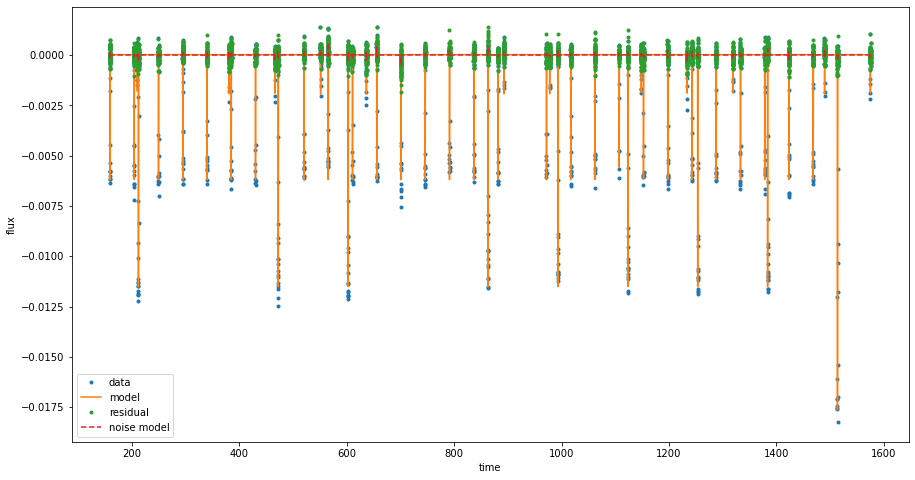

In [13]:
plt.figure(figsize=(15,8))
#plt.xlim(1512, 1515)
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(t, f, '.', label='data')
plt.plot(t, fpred, '-', label='model')
plt.plot(t, f-fpred, '.', label='residual')
plt.plot(tpred, gppred, '--', label='noise model')
plt.legend(loc='best');

In [14]:
def check_folded_transits(t, f, e, fmodel, t0s, ps, bin_frac=1e-4):
    for j ,(t0, p) in enumerate(zip(t0s, ps)):
        tp, fp, ep = phasefold(t, f, e, t0, p)
        tbin, fbin, ebin, _ = binning(tp, fp, p*bin_frac)
        tm, fm, _ = phasefold(t, fmodel, fmodel*0, t0, p)
        fmin = np.min(fbin[np.abs(tbin)<0.5])
        plt.figure(figsize=(10,5))
        plt.title("planet %d"%(j+1))
        plt.ylabel("flux")
        plt.xlabel("time (days)")
        plt.ylim(1.5*fmin, -0.5*fmin)
        plt.xlim(-0.5, 0.5)
        plt.plot(tbin, fbin, 'o', mfc='none', label='folded and binned data')
        plt.plot(tm, fm, '.', markersize=3, zorder=-1000, label='model')
        plt.legend(loc='lower right');

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3237: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


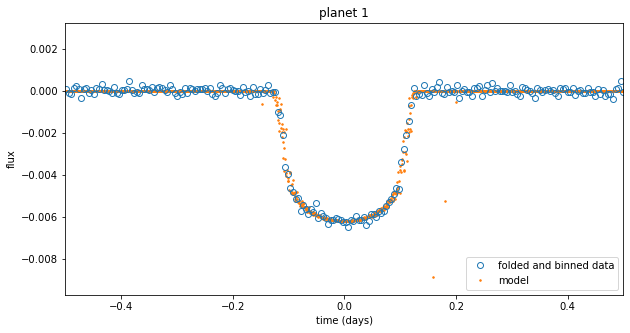

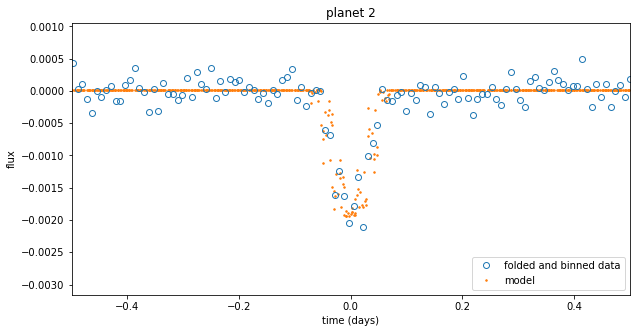

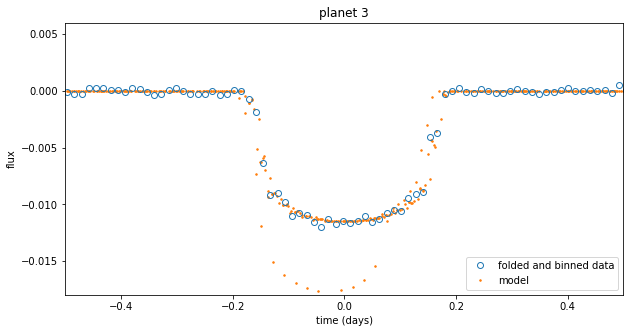

In [15]:
check_folded_transits(t, f, e, fpred, popt['t0'], popt['period'])

### TTVs from initial optimization

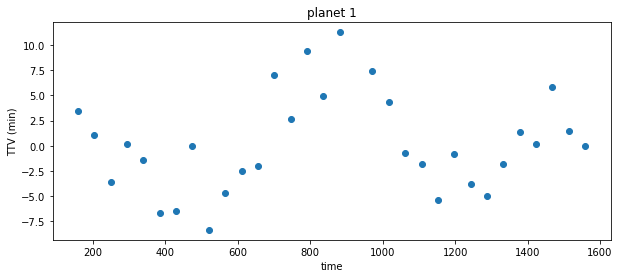

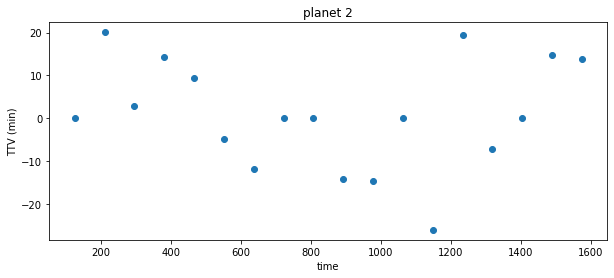

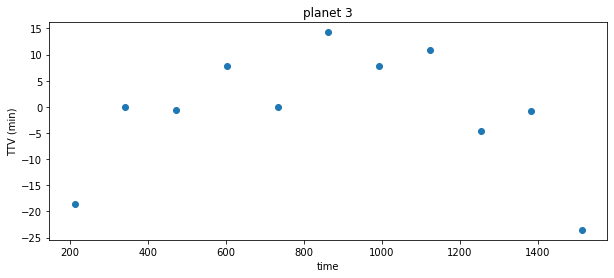

In [16]:
for j, (t0, p) in enumerate(zip(popt['t0'], popt['period'])):
    tc_lin = t0 + tf.transit_idx_set[j] * p
    ttv = popt['ttv%d'%j]
    plt.figure(figsize=(10,4))
    plt.title("planet %d"%(j+1))
    plt.xlabel("time")
    plt.ylabel("TTV (min)")
    plt.errorbar(tc_lin, 1440*ttv, fmt='o')

## run HMC

In [17]:
import jax.numpy as jnp
import numpyro
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random
from celerite2.jax import terms as jax_terms
import celerite2


def model(tf, flux, error, t0_guess, p_guess, 
          rstar_min=0.1, rstar_max=2., mean_width=1e-4, rp_min=1e-3, rp_max=0.2, maxttv=0.2, gpprior=True):
    ones = jnp.ones_like(t0_guess)
    t0, period = t0_guess, p_guess
    ecc = ones * 0.
    omega = ones * 0.
    b = numpyro.sample("b", dist.Uniform(ones*0., ones+rp_max))
    lnrp = numpyro.sample("lnrp", dist.Uniform(ones*jnp.log(rp_min), ones*jnp.log(rp_max)))
    rp = numpyro.deterministic("rp", jnp.exp(lnrp))
    
    # stellar parameters and a/Rstar
    mstar = 1.
    rstar = numpyro.sample("rstar", dist.Uniform(rstar_min, rstar_max))
    a = numpyro.deterministic("a", a_over_rstar_kep3(period, mstar, rstar))
    
    # limb darkening
    q1 = numpyro.sample("q1", dist.Uniform(0,1))
    q2 = numpyro.sample("q2", dist.Uniform(0,1))
    u1, u2 = q_to_u(q1, q2)

    # compute flux model with TTVs
    npl = len(ones)
    ttvs = [numpyro.sample("ttv%d"%j, 
                           dist.Uniform(low=-maxttv*jnp.ones(tf.transit_nums[j]), 
                                        high=maxttv*jnp.ones(tf.transit_nums[j])
                                       )
                          ) for j in range(npl)]       
    for j in range(npl):
        tc_linear_j = t0[j] + tf.transit_idx_set[j] * period[j]
        numpyro.deterministic("tc%d"%j, tc_linear_j + ttvs[j])
        if gpprior:
            lnttvampj = numpyro.sample("lnttvamp%d"%j, dist.Uniform(low=jnp.log(1e-6), high=jnp.log(0.1*period[j])))
            lnttvtauj = numpyro.sample("lnttvtau%d"%j, dist.Uniform(low=jnp.log(0.5*period[j]), high=jnp.log(5*(jnp.max(t)-jnp.min(t)))))
            kernel = jax_terms.Matern32Term(sigma=jnp.exp(lnttvampj), rho=jnp.exp(lnttvtauj))
            gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
            gp.compute(tc_linear_j)
            numpyro.factor("loglikettv%d"%j, gp.log_likelihood(ttvs[j]))
    fluxmodel = tf.compute_flux_with_ttv(t0, period, ecc, omega, b, a, rp, u1, u2, ttvs)
    numpyro.deterministic("fluxmodel", fluxmodel)
    
    # subtract mean
    if mean_width != 0.:
        mwabs = jnp.abs(mean_width)
        meanflux = numpyro.sample("meanflux", dist.Uniform(-mwabs, mwabs))
    else:
        meanflux = 0.
    residual = flux - fluxmodel - meanflux
    
    # noise model using GP
    lna = numpyro.sample("lna", dist.Uniform(low=-14, high=-4))
    lnc = numpyro.sample("lnc", dist.Uniform(low=-5, high=2))
    lnjitter = numpyro.sample("lnjitter", dist.Uniform(low=-14, high=-4))
    jitter = numpyro.deterministic("jitter", jnp.exp(lnjitter))
    
    kernel = jax_terms.Matern32Term(sigma=jnp.exp(lna), rho=jnp.exp(lnc))
    gp = celerite2.jax.GaussianProcess(kernel, mean=0.0)
    gp.compute(tf.t, diag=error**2 + jitter**2)
    numpyro.sample("obs", gp.numpyro_dist(), obs=residual)

In [18]:
pdic_init = dict(popt)

In [19]:
pdic_init

{'b': DeviceArray([4.60355503e-02, 9.83043185e-01, 1.00000000e-04], dtype=float64),
 'ecc': DeviceArray([0., 0., 0.], dtype=float64),
 'lna': DeviceArray(-8.77657317, dtype=float64),
 'lnc': DeviceArray(-1.535741, dtype=float64),
 'lnjitter': DeviceArray(-9.18590511, dtype=float64),
 'meanflux': DeviceArray(1.45169826e-05, dtype=float64),
 'omega': DeviceArray([0., 0., 0.], dtype=float64),
 'period': DeviceArray([ 45.15524614,  85.31644914, 130.17703195], dtype=float64),
 'q1': DeviceArray(0.36, dtype=float64),
 'q2': DeviceArray(0.33333333, dtype=float64),
 'rp': DeviceArray([0.07199682, 0.0656596 , 0.09808588], dtype=float64),
 'rstar': DeviceArray(0.83371121, dtype=float64),
 't0': DeviceArray([159.10724591, 295.31393868, 212.03704526], dtype=float64),
 'ttv0': DeviceArray([ 2.40971060e-03,  7.30703380e-04, -2.47183543e-03,
               1.14048519e-04, -9.90598281e-04, -4.63806132e-03,
              -4.47017361e-03,  0.00000000e+00, -5.79208727e-03,
              -3.21973092e-03, 

In [20]:
init_strategy = init_to_value(values=pdic_init)

In [21]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.95, init_strategy=init_strategy)

In [22]:
nw, ns = 500, 500 # ~1hr

In [23]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [24]:
output = "transit-ttv_mcmc.pkl"

In [25]:
if os.path.exists(output):
    print (output + " loaded.")
    mcmc = dill.load(open(output, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, tf, f, e, pdic_init['t0'], pdic_init['period'])
    with open(output, "wb") as fout:
        dill.dump(mcmc, fout)

transit-ttv_mcmc.pkl loaded.


In [26]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       b[0]      0.09      0.06      0.08      0.00      0.17    155.37      1.01
       b[1]      0.98      0.02      0.98      0.96      1.00    326.69      1.00
       b[2]      0.08      0.06      0.06      0.00      0.16    153.70      1.01
        lna     -8.70      0.08     -8.70     -8.83     -8.57    197.92      1.00
        lnc     -1.90      0.31     -1.86     -2.41     -1.42     94.42      1.00
   lnjitter     -9.48      0.77     -9.22    -10.73     -8.90     29.43      1.01
    lnrp[0]     -2.63      0.00     -2.63     -2.63     -2.62    215.27      1.00
    lnrp[1]     -2.77      0.15     -2.79     -2.99     -2.53    327.50      1.00
    lnrp[2]     -2.32      0.00     -2.32     -2.32     -2.31    227.89      1.00
  lnttvamp0     -5.73      0.31     -5.75     -6.23     -5.23    191.48      1.00
  lnttvamp1     -4.56      0.28     -4.60     -5.00     -4.10    433.35      1.00
  lnttvamp2    

In [28]:
samples = mcmc.get_samples()

## TTV posterior

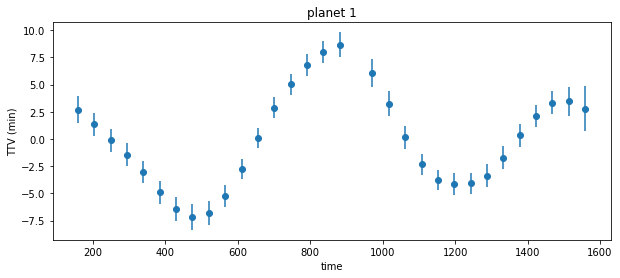

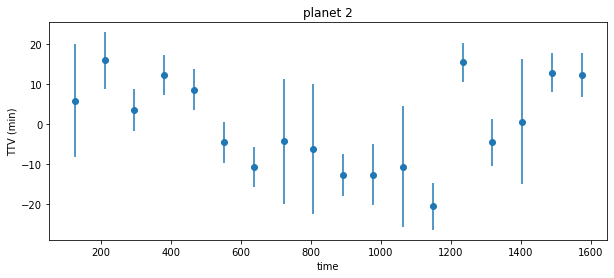

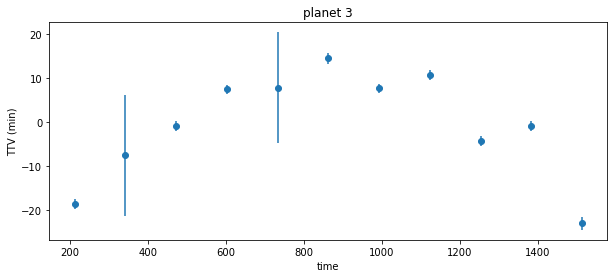

In [29]:
for j, (t0, p) in enumerate(zip(pdic_init['t0'], pdic_init['period'])):
    tc_lin = t0 + tf.transit_idx_set[j] * p
    tc_mean = np.mean(samples['tc%d'%j], axis=0)
    tc_std = np.std(samples['tc%d'%j], axis=0)
    plt.figure(figsize=(10,4))
    plt.title("planet %d"%(j+1))
    plt.xlabel("time")
    plt.ylabel("TTV (min)")
    plt.errorbar(tc_lin, 1440*(tc_mean - tc_lin), fmt='o', yerr=1440*tc_std);

## corner plots

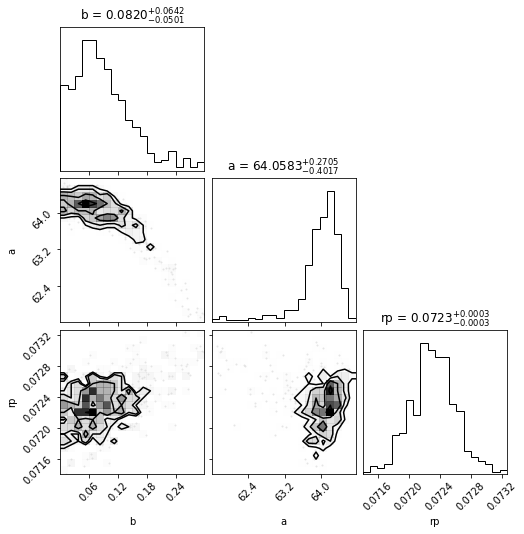

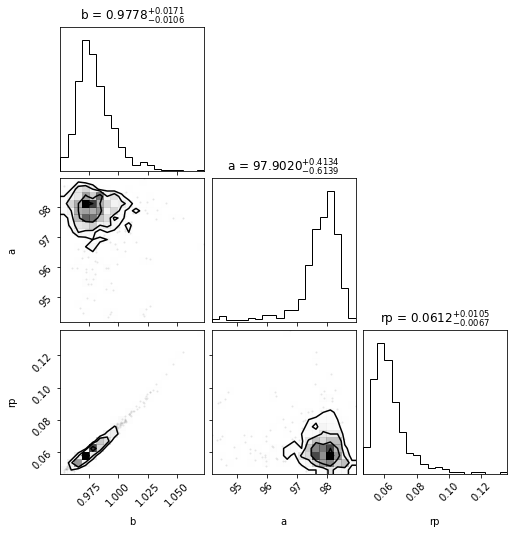

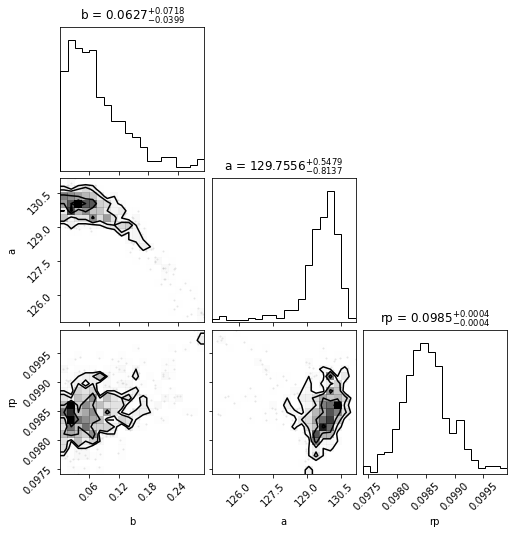

In [30]:
keys = ['b', 'a', 'rp']
for j in range(len(dkoi)):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles=True, title_fmt=".4f")

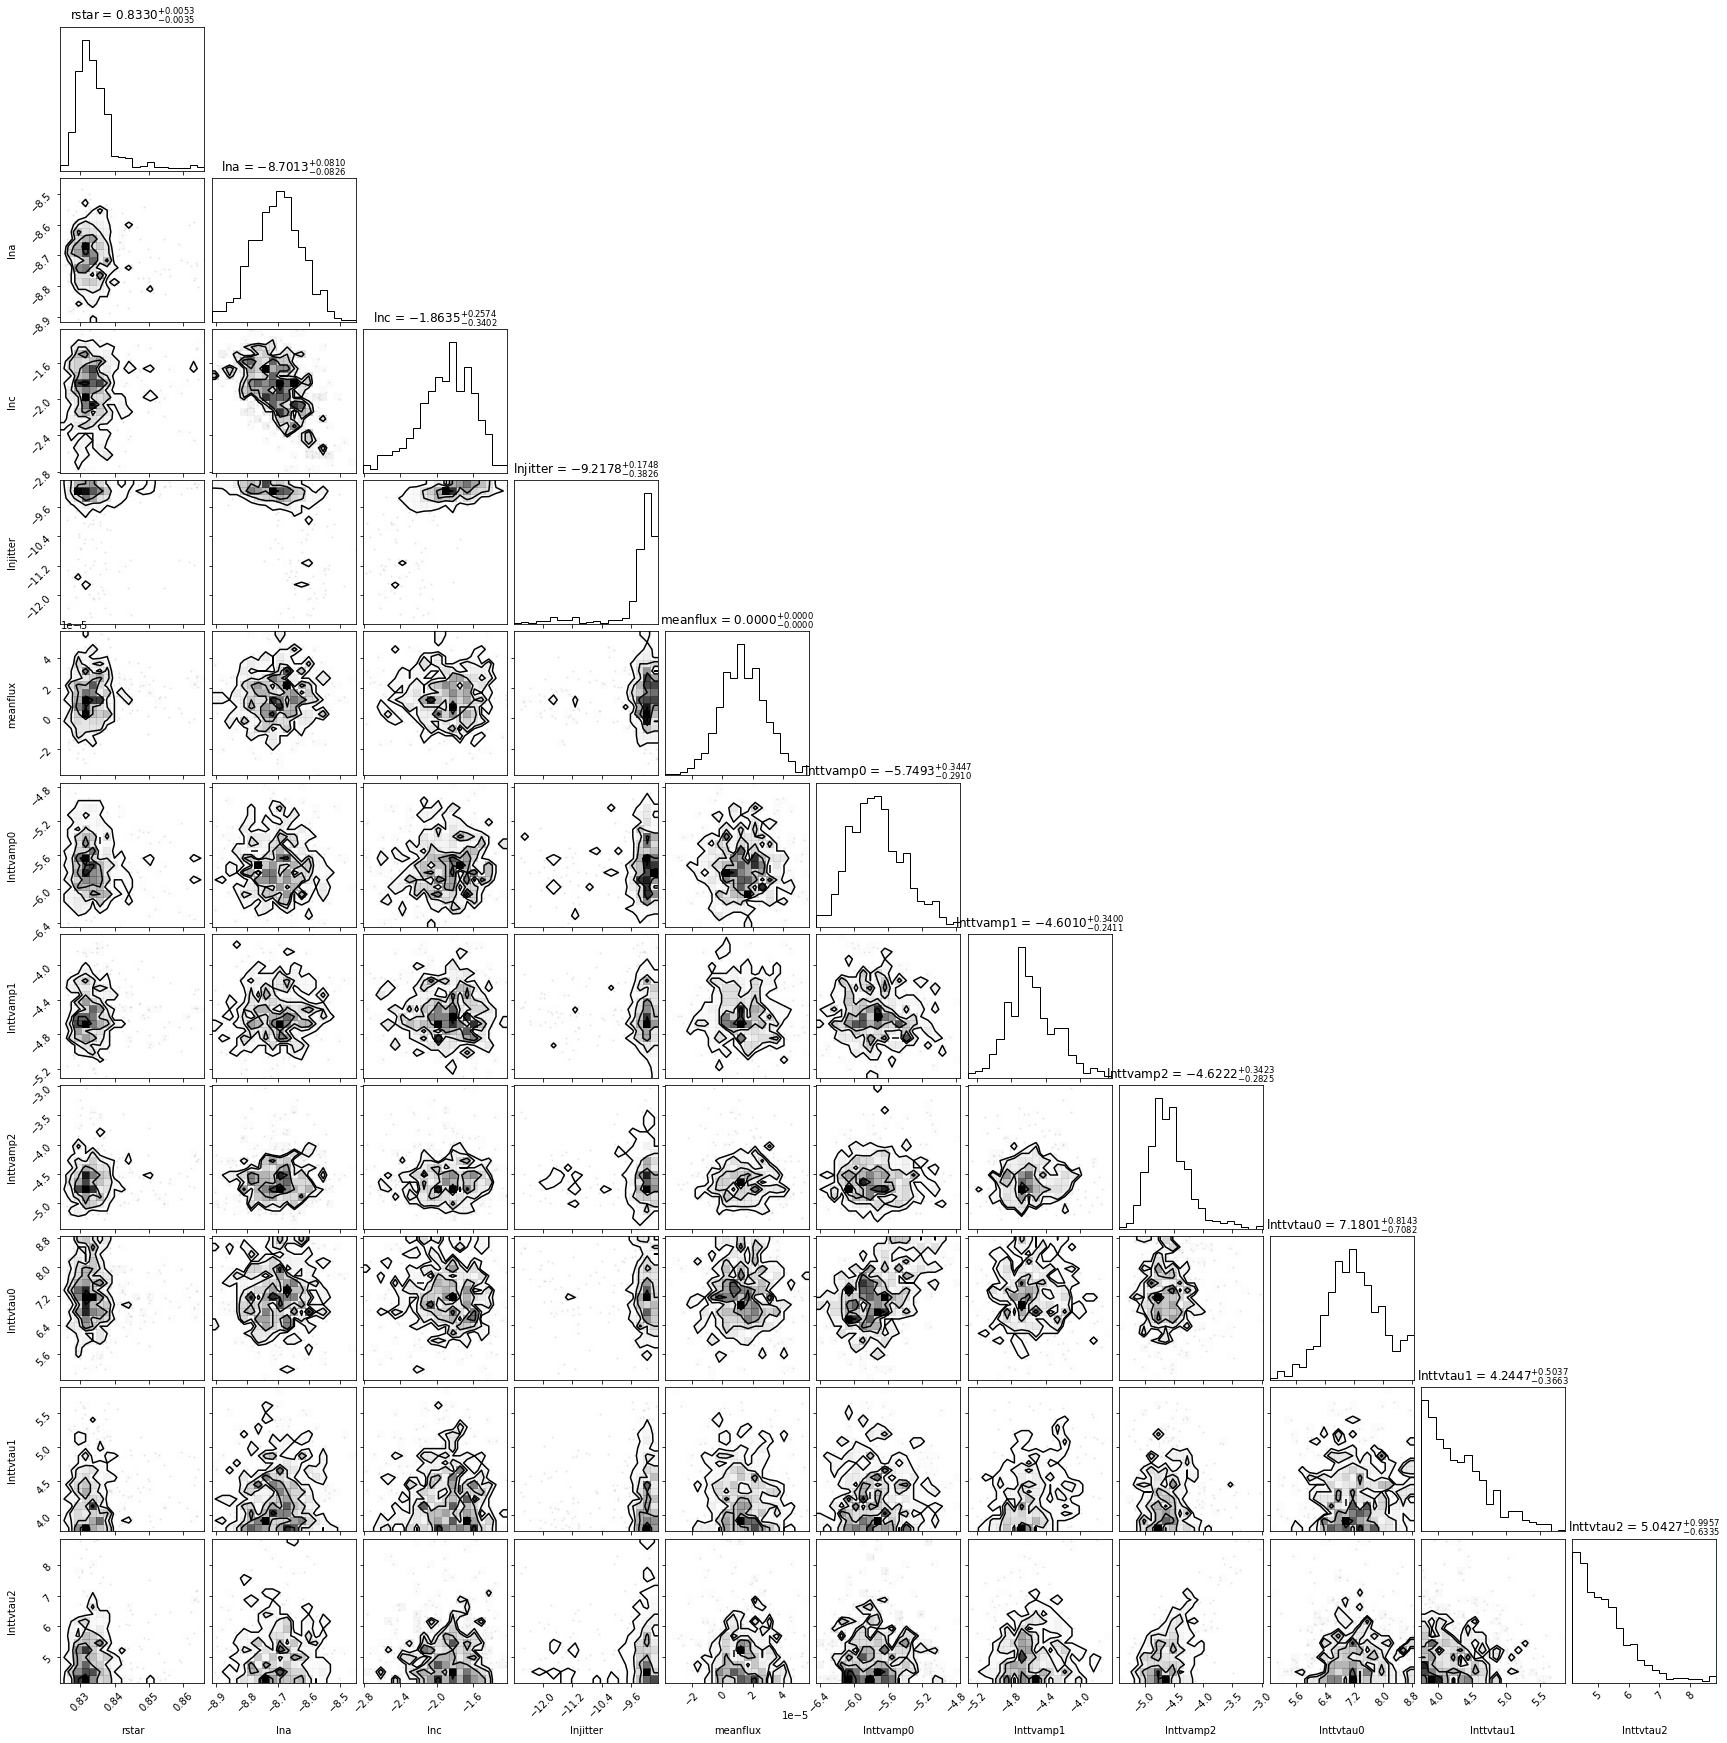

In [31]:
keys = ['rstar', 'lna', 'lnc', 'lnjitter', 'meanflux']
keys += ['lnttvamp%d'%j for j in range(3)]
keys += ['lnttvtau%d'%j for j in range(3)]
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
fig = corner.corner(hyper, labels=keys, show_titles=True, title_fmt=".4f")

## check model again

In [32]:
meanf = np.array(np.mean(samples['fluxmodel'], axis=0))

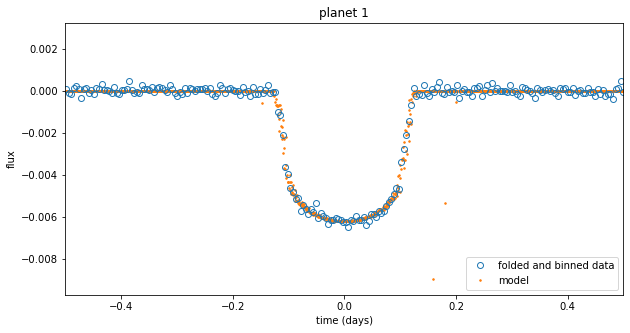

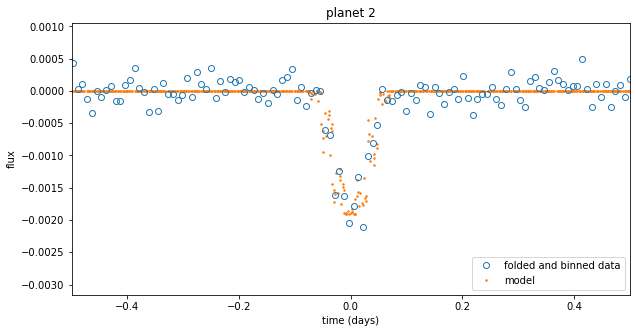

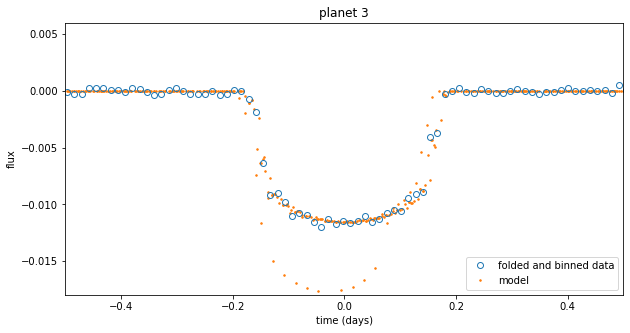

In [34]:
check_folded_transits(t, f, e, meanf, pdic_init['t0'], pdic_init['period'])